# Инициализация.

In [54]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, Latex
from numba import njit, jit, prange
from itertools import product
from scipy import integrate
from scipy import special
from tqdm import tqdm

sns.set_style("whitegrid")

# Загрузка и предпросмотр.

In [55]:
# Закон Парето или другие данные.
# x = scipy.stats.pareto.rvs(1.5, size=200)

# Синтетические нормально распределённые (тест).
# x = np.random.randn((200))

# Синтетические равномерно распределённые (тест).
# x = np.random.uniform(1, 10, size=200)

# Синтетические экспоненциально распределённые (тест).
x = scipy.stats.expon.rvs(size=200)

x = x[x > 0]

## Метод Хилла

In [56]:
@njit(parallel=True)
def compute_hill_values(x):
    sorted_x = np.sort(x)[::-1]
    hill_values = np.zeros(sorted_x.size - 1)
    for k in prange(1, sorted_x.size):
        hill_values[k - 1] = np.sum(np.log(sorted_x[:k] / sorted_x[k])) / k
    return sorted_x, hill_values

In [57]:
sorted_x, hill_values = compute_hill_values(x)
ks = np.arange(1, sorted_x.size)
beta = np.median(hill_values) ** -1
alpha = beta + 1
display(Latex(f'$\\alpha={alpha}$'))

<IPython.core.display.Latex object>

In [58]:
beta = np.median(hill_values) ** -1
alpha = beta + 1
display(Latex(f'$\\alpha={alpha}$'))

<IPython.core.display.Latex object>

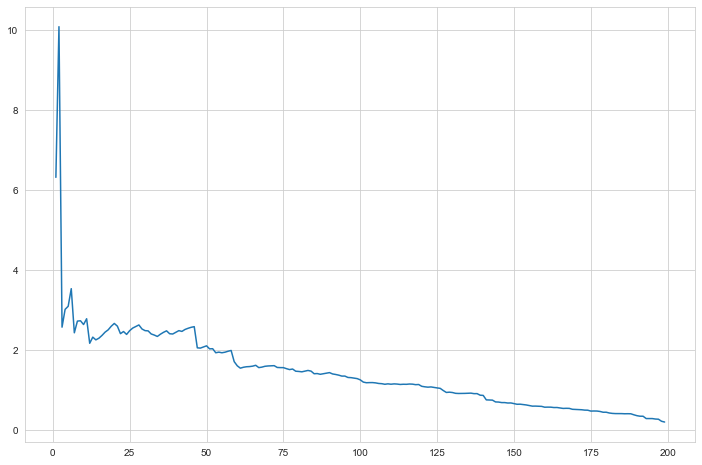

In [59]:
plt.figure(figsize=(12, 8))
plt.plot(ks, hill_values ** -1)
plt.show()

## Линейный биннинг

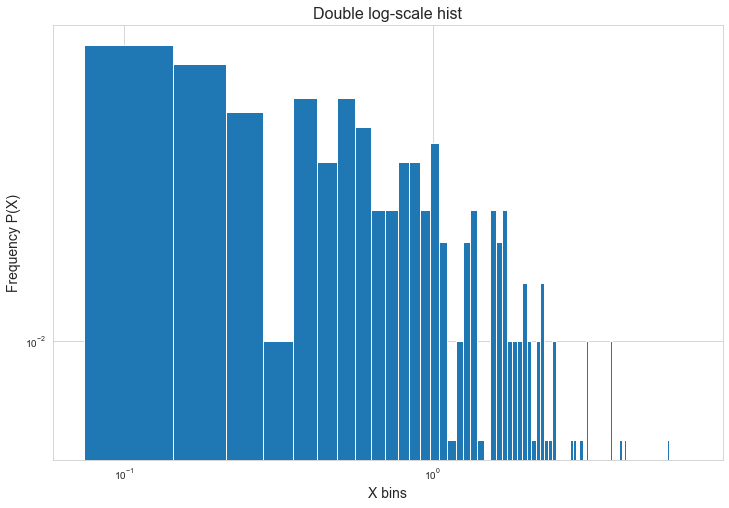

In [60]:
lin_bins_count = 100
x_bins = np.linspace(x.min(), x.max(), num=lin_bins_count + 1)

cdf = np.array([sum(x < bin) for bin in x_bins]) / x.shape[0]
bins_frequences = cdf[1:] - cdf[:-1]

plt.figure(figsize=(12, 8))
plt.hist(x_bins[:-1], x_bins[1:], weights=bins_frequences)

plt.yscale('log')
plt.xscale('log')

plt.xlabel('X bins', fontsize=14)
plt.ylabel('Frequency P(X)', fontsize=14)
plt.title("Double log-scale hist", fontsize=16)

plt.show()

# Тест Pruessner

## Биннинг

In [61]:
@njit
def get_exp_bins(selection, bins_count):
    R = (selection.max() / selection.min()) ** (1 / bins_count)
    c = selection.min() / R
    linspace = np.arange(bins_count) * ((bins_count) / (bins_count - 1)) + 1
    bins = c * R ** linspace
    return bins

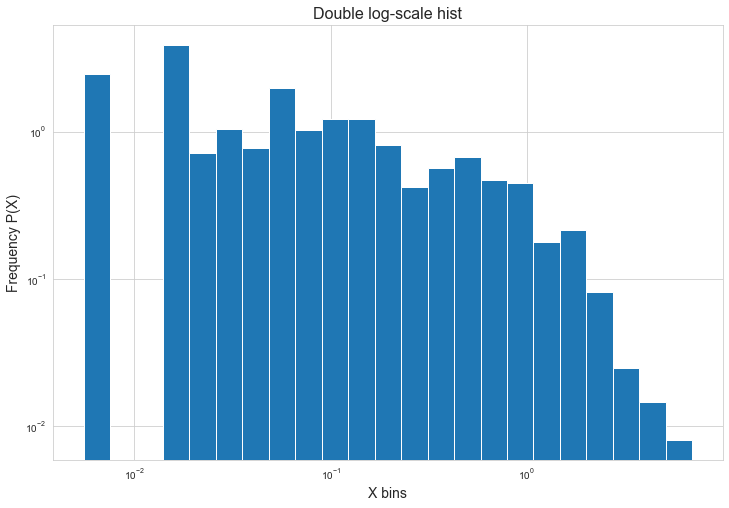

In [62]:
exp_bins_count = 25
x_exp_bins = get_exp_bins(x, exp_bins_count)

pdf = np.array([np.sum([(x >= bin_start) & (x < bin_end)]) for bin_start, bin_end in zip(x_exp_bins[:-1], x_exp_bins[1:])]) / x.shape[0]
pdf_exp = pdf / (x_exp_bins[1:] - x_exp_bins[:-1])

plt.figure(figsize=(12, 8))
plt.hist(x_exp_bins[:-1], x_exp_bins[1:], weights=pdf_exp)

plt.yscale('log')
plt.xscale('log')

plt.xlabel('X bins', fontsize=14)
plt.ylabel('Frequency P(X)', fontsize=14)
plt.title("Double log-scale hist", fontsize=16)

plt.show()

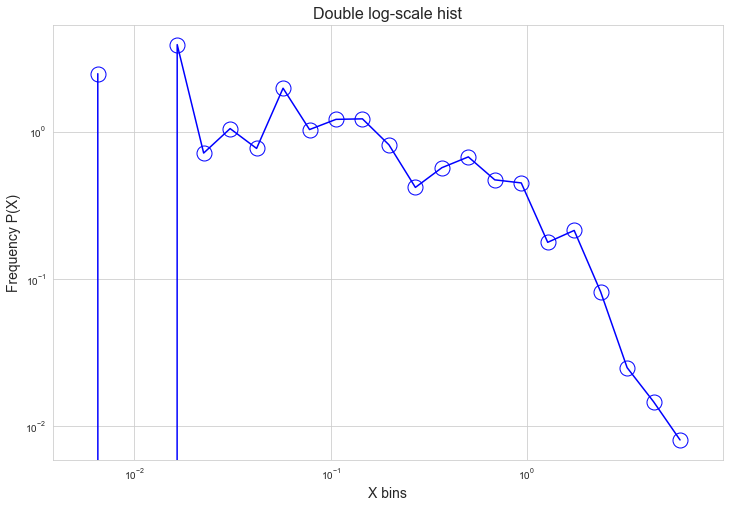

In [63]:
figure = plt.gcf()

n, bins, _ = plt.hist(x_exp_bins[:-1], x_exp_bins[1:], weights=pdf_exp, alpha=0.0)
plt.plot(bins[:-1] + 0.5 * (bins[1:] - bins[:-1]), n, 'b-', marker="o", markersize=15, markerfacecolor="None")

plt.yscale('log')
plt.xscale('log')

plt.xlabel('X bins', fontsize=14)
plt.ylabel('Frequency P(X)', fontsize=14)
plt.title("Double log-scale hist", fontsize=16)

size = figure.get_size_inches()
figure.set_size_inches(size * (12.0 / size[0]))

plt.show()

## Нелинейное преобразование координат.

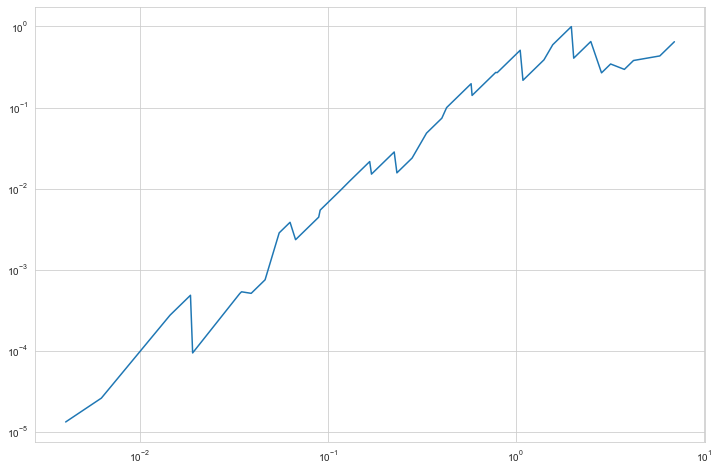

In [64]:
new_pdf = x.copy()
for index, (bin_start, bin_end) in enumerate(zip(x_exp_bins[:-1], x_exp_bins[1:])):
    new_pdf[(x >= bin_start) & (x < bin_end)] **= alpha
    new_pdf[(x >= bin_start) & (x < bin_end)] *= pdf_exp[index]

plt.figure(figsize=(12, 8))

sorted_idxs = np.argsort(x)
plt.plot(x[sorted_idxs], new_pdf[sorted_idxs])

plt.yscale('log')
plt.xscale('log')

plt.show()

# Тест Clauset

## Оценка параметра $x_{min}$.

Предполагаем, что данные распределены непрерывно по степенному закону:

> $p(x)dx = Pr(x \leq X \leq x + dx) =  \frac{\alpha-1}{x_{min}}\cdot\left(\frac{x}{x_{min}}\right)^{-\alpha}dx$

Для того, чтобы оценить $x_{min}$ воспользуемся следующим критерием: подберём такую степенную модель $M(\hat{\alpha}, \hat{x}_{min})$, для которой $D_{KS}=\underset{x\geq \hat{x}_{min}}{max}\left|\overline{CDF}(x)-CDF_{M}(x)\right|$ минимально. Тогда $\hat{x}_{min}$ и будет нашим оценочным значением.

In [65]:
@njit
def m_density_func(x, alpha, x_min):
    return ((alpha - 1) / x_min) * (x / x_min) ** (-alpha)

@njit
def m_cdf(x, alpha, x_min):
    return (x / x_min) ** (1 - alpha)

In [66]:
@njit
def fast_ks_test(x, exp_bins_count, alpha, x_min):
    x_filtered = x[x >= x_min]
    
    if x_filtered.shape[0] < exp_bins_count:
        exp_bins_count = x_filtered.shape[0]
    if exp_bins_count < 2:
        return np.inf, np.empty(1), np.empty(1)
        
    exp_bins = get_exp_bins(x_filtered, exp_bins_count)
    exp_bins_counts = np.zeros(exp_bins.shape[0] - 1)
    for index, exp_bin in enumerate(exp_bins[:-1]):
        exp_bins_counts[index] = np.sum(x_filtered >= exp_bin)
    bins_cdf = exp_bins_counts / x_filtered.shape[0]

    # Так как в данном случае CDF монотонно убывает (CDF(x) = P(X >= x)).
    m_bins_cdf = m_cdf(exp_bins[:-1], alpha, x_min)

    ks_distance = np.max(np.abs(bins_cdf - m_bins_cdf))

    return ks_distance, bins_cdf, m_bins_cdf

Подберём оптимальное значение по сетке. Среди одних и тех же значений x_min выбираем минимальное расстояние Колмогорова-Смирнова, получаем соответствие между каждым уникальным x_min и его расстоянием. Находим самый левый локальный минимум с глубиной, большей или равной заданной.

In [67]:
@njit
def find_left_min(values, min_depth): 
    left_ptr = 0
    right_ptr = 0

    if values.size == 1:
        return 0

    while right_ptr != (values.size - 1) and values[right_ptr] < values[right_ptr + 1]:
        right_ptr += 1
    if right_ptr == (values.size - 1):
        return 0

    left_ptr = right_ptr

    while right_ptr < (values.size - 1):
        if values[right_ptr] >= values[right_ptr + 1]:
            right_ptr += 1

        else:
            left_depth = values[left_ptr] - values[right_ptr]
            if left_depth < min_depth:
                right_ptr += 1
                continue
            left_ptr = right_ptr
            while right_ptr < (values.size - 1):
                if values[right_ptr] < values[left_ptr]:
                    left_ptr = right_ptr
                if values[right_ptr] < values[right_ptr + 1]:
                    right_ptr += 1
                else:
                    right_depth = values[right_ptr] - values[left_ptr]
                    if right_depth < min_depth:
                        right_ptr += 1
                        continue
                    else:
                        break

            if right_ptr == (values.size - 1):
                right_depth = values[right_ptr] - values[left_ptr]
            if min(left_depth, right_depth) >= min_depth:
                return left_ptr
            else:
                left_ptr = right_ptr
    
    return -1

In [68]:
from collections import defaultdict

MIN_ALPHA = 1 + 1e-8
MIN_X_MIN = 0 + 1e-8

alphas_counts = 90
xs_min_counts = 20
total = alphas_counts * xs_min_counts

alphas = np.linspace(MIN_ALPHA, 10, alphas_counts)
xs_min = get_exp_bins(np.array([MIN_X_MIN, x.max()]), xs_min_counts)

best_x_min = None
best_bins_cdfs = None

ks_history = defaultdict(lambda: np.inf)
bins_cdfs_history = dict()

min_ks_distance = np.inf 
for (alpha, x_min) in tqdm(product(alphas, xs_min), "Searching x_min", total):
    ks_distance, *bins_cdfs = fast_ks_test(x, exp_bins_count, alpha, x_min)
    
    if ks_distance < ks_history[x_min]:
        ks_history[x_min] = ks_distance
        bins_cdfs_history[x_min] = bins_cdfs

Searching x_min: 100%|██████████████████████████████| 1800/1800 [00:00<00:00, 2706.38it/s]


In [69]:
min_depth = 0.5
history_values = np.array(list(ks_history.values()))

min_ptr = find_left_min(history_values, min_depth)
while min_ptr == -1 or np.abs(history_values[min_ptr]) < 1e-8:
    min_depth -= 1e-2
    if min_depth <= 0:
        break
    min_ptr = find_left_min(history_values, min_depth)

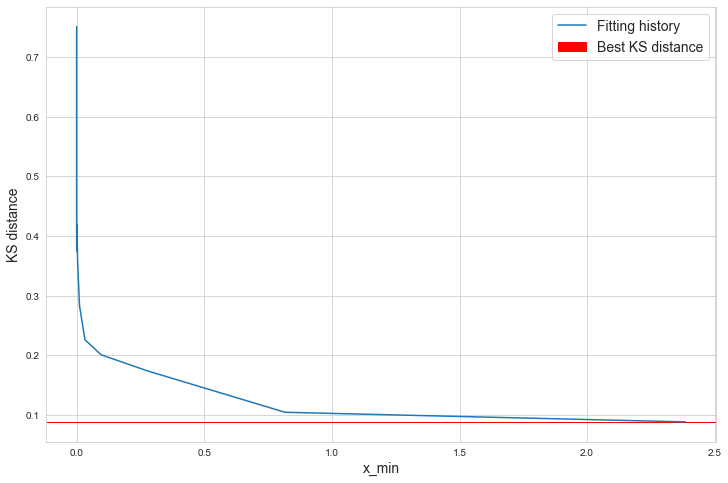

In [70]:
min_ks_distance = history_values[min_ptr]

plt.figure(figsize=(12, 8))

plt.plot(list(ks_history.keys()), list(ks_history.values()), label="Fitting history")
plt.xlabel('x_min', fontsize=14)
plt.ylabel('KS distance', fontsize=14)

plt.axhspan(min_ks_distance, min_ks_distance + 1e-4, color='red', label="Best KS distance")

plt.legend(fontsize=14)
plt.show()

In [71]:
best_x_min = list(ks_history.keys())[min_ptr]
best_bins_cdfs = bins_cdfs_history[best_x_min]

In [72]:
display(Latex(f'$x_{"{min}"}=\hat{"{x}"}_{"{min}"}={best_x_min}$'))
display(Latex(f'$min(D_{"{KS}"})={min_ks_distance}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

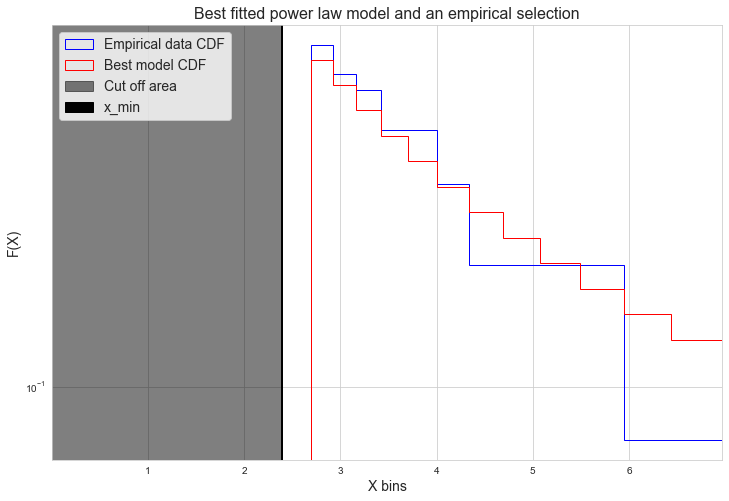

In [73]:
plt.figure(figsize=(12, 8))

bins_cdf = best_bins_cdfs[0]
m_bins_cdf = best_bins_cdfs[1]

x_filtered = x[x >= best_x_min]
if x_filtered.shape[0] < exp_bins_count:
        exp_bins_count = x_filtered.shape[0]
exp_bins = get_exp_bins(x_filtered, exp_bins_count)

bins_starts = exp_bins[:-1]
bins_ends = exp_bins[1:]

plt.hist(bins_starts, bins_ends, weights=bins_cdf, color='blue', 
         histtype = 'step', label='Empirical data CDF')
plt.hist(bins_starts, bins_ends, weights=m_bins_cdf, color='red', 
         histtype = 'step', label='Best model CDF')

plt.xlabel('X bins', fontsize=14)
plt.ylabel('F(X)', fontsize=14)
plt.title("Best fitted power law model and an empirical selection", fontsize=16)

plt.axvspan(x.min(), best_x_min, 0, 1, alpha=0.5, color='black', label='Cut off area')
plt.axvspan(best_x_min, best_x_min + 1e-2, 0, 1, color='black', label='x_min')

plt.xlim(x.min(), x.max())

plt.yscale('log')
plt.legend(fontsize=14)
plt.show()

## Оценка параметра $\alpha$.

На данном этапе считаем, что $x_{min}$ нам известен. 

In [74]:
x_min = best_x_min

Оценка параметра $\alpha$ производится с помощью метода максимального правдоподобия. В данном случае MLE модель может быть записана в виде:

> $\hat{\alpha}=1 + n\left[\underset{i=1}{\overset{n}{\sum}}ln\frac{x_i}{x_{min}}\right]^{-1}$,

где $x_i, i=1,\cdots, n$ - наблюдаемые значения переменной x такие, что $x_i \geq x_{min}$; $\hat{\alpha}$ - спрогнозированное значение $\alpha$.

In [75]:
filtered_x = x[x >= x_min]
n = filtered_x.shape[0]

alpha = np.round(1 + n * (np.sum(np.log(filtered_x / x_min)) ** (-1)), 3)

In [76]:
display(Latex(f'$\\alpha={alpha}$'))

<IPython.core.display.Latex object>

## Тестирование на принадлежность выборки к степенному распределению.

Для вычисления $p$-статистики нам понадобится сгенерировать некоторое количество новых выборок данных из степенного распределения с параметрами ($\hat{\alpha}$, $\hat{x}_{min}$). Количество новых синтетических датасетов зависит от точности $ϵ$: если мы хотим, чтобы наша $p$-статистика имела ошибку не более $ϵ$, то необходимо сгенерировать $N \geq \frac{1}{4}ϵ^{-2}$ наборов данных.

In [77]:
eps = 1e-2 # Выбор параметра epsilon.

synth_n = round(0.25 * (eps ** (-2)))
display(Latex(f'$\\epsilon={eps}\Rightarrow N={synth_n}$'))

<IPython.core.display.Latex object>

Генерируем датасеты так, чтобы та же часть набора данных, что и в эмпирической выборке $x\geq \hat{x}_{min}$, была распределена по степенному закону ($\hat{\alpha}$, $\hat{x}_{min}$), а остальная часть $x<\hat{x}_{min}$ была представлена выбранными равномерно случайными данными из соответствующей части базовой выборки. 

In [78]:
@njit
def power_law_generate(alpha, x_min, probability):
    # Так как x_min > 0, функция плотности ax^b монотонна => можно построить 
    # биективное отображение из значений F(x) в x.
    return (x_min ** (1 - alpha) * probability) ** (1 / (1 - alpha))

@njit
def generate_dataset(alpha, x_min, x, number_of_samples):
    n_tail = np.sum(x >= x_min)
    n_empirical = number_of_samples - n_tail

    power_law_probs = np.random.uniform(0, 1, number_of_samples)
    power_law_generated = power_law_generate(alpha, x_min, power_law_probs)

    if n_empirical != 0:
        random_values = np.random.uniform(0, 1, number_of_samples)
        random_samples = np.random.choice(x[x < x_min], number_of_samples)
        return np.where(random_values >= n_empirical / number_of_samples, 
                        power_law_generated, random_samples)
    else:
        return power_law_generated

Вычислим $p$-статистику: (крайне времязатратный шаг)

In [79]:
@njit(parallel=True)
def compute_p_value(alpha, x_min, x, synth_n, empirical_ks, alphas, xs_min):
    ks_statistics = np.zeros(synth_n)
    for index in prange(synth_n):
        ks_synth_history = np.ones(xs_min_counts) * np.inf
        for alpha_index in np.arange(alphas.size):
            for x_min_index in np.arange(xs_min.size):
                alpha_ = alphas[alpha_index]
                x_min_ = xs_min[x_min_index]

                dataset = generate_dataset(alpha, x_min, x, x.shape[0])
                ks_distance, _, _ = fast_ks_test(dataset, exp_bins_count, alpha_, x_min_)
                if ks_distance < ks_synth_history[x_min_index]:
                    ks_synth_history[x_min_index] = ks_distance

            min_synth_ptr = find_left_min(ks_synth_history, min_depth)
            ks_statistics[index] = ks_synth_history[min_synth_ptr]

    p_value = np.sum(ks_statistics > empirical_ks) / synth_n

    return p_value, ks_statistics

In [80]:
p_value, ks_statistics = compute_p_value(alpha, x_min, x, synth_n, min_ks_distance, alphas, xs_min)
display(Latex(f'$p={p_value}$'))

<IPython.core.display.Latex object>

In [81]:
if p_value >= 0.1 + eps:
    display(Latex('$p\geq 0.1\Rightarrow гипотеза\; на\; соответствие\; \
     распределения\; выборки\; степенному\; закону\; принимается.$'))
else:
    display(Latex('$p< 0.1\Rightarrow гипотеза\; на\; соответствие\; \
     распределения\; выборки\; степенному\; закону\; отвергается.$'))

<IPython.core.display.Latex object>